In [1]:
import cv2
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import time
from skimage.morphology import dilation
from skimage.feature import canny
from skimage import color

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
IMAGE_DIR = "input"
MASK_DIR = "disc_masks"
BATCH_SIZE = 4

In [4]:
def convolution_block(input_tensor, num_filters):
    # Apply two convolutional layers with ReLU activation
    x = tf.keras.layers.Conv2D(
        num_filters,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"
    )(input_tensor)
    x = tf.keras.layers.Conv2D(
        num_filters,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_initializer="he_normal"
    )(x)
    return x

def encoder_block(input_tensor, num_filters):
    # Encoder block: Convolution followed by max pooling and dropout
    convolved_features = convolution_block(input_tensor, num_filters)
    pooled_features = tf.keras.layers.MaxPool2D(pool_size=2)(convolved_features)
    pooled_features = tf.keras.layers.Dropout(rate=0.3)(pooled_features)
    return convolved_features, pooled_features

def decoder_block(input_tensor, skip_connections, num_filters):
    # Decoder block: Transposed convolution, concatenation with skip connection, dropout
    x = tf.keras.layers.Conv2DTranspose(
        num_filters,
        kernel_size=3,
        strides=2,
        padding="same"
    )(input_tensor)
    # Concatenate the upsampled feature map with the corresponding cropped feature map from the encoder
    x = tf.keras.layers.concatenate([x, skip_connections])
    # Apply dropout and two convolutional layers
    x = tf.keras.layers.Dropout(rate=0.3)(x)
    # Apply two convolutional layers
    x = convolution_block(x, num_filters)
    return x

def build_UNET(input_shape=(128, 128, 3), output_channels=1):
    # Define the input tensor
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Constructing the encoder (downsampling path)
    conv1, pool1 = encoder_block(inputs, 32)
    conv2, pool2 = encoder_block(pool1, 64)
    conv3, pool3 = encoder_block(pool2, 128)
    conv4, pool4 = encoder_block(pool3, 256)
    
    # Bottleneck part of the network
    bottleneck_features = convolution_block(pool4, 512)

    # Constructing the decoder (upsampling path)
    up1 = decoder_block(bottleneck_features, conv4, 256)
    up2 = decoder_block(up1, conv3, 128)
    up3 = decoder_block(up2, conv2, 64)
    up4 = decoder_block(up3, conv1, 32)

    # Final output layer with sigmoid activation
    final_output = tf.keras.layers.Conv2D(
        output_channels,
        kernel_size=1,
        padding="same",
        activation="sigmoid"
    )(up4)

    # Assembling the full model
    unet_model = tf.keras.Model(inputs=inputs, outputs=final_output, name="Enhanced_U-Net")
    return unet_model



In [5]:

def load_images(image_path, mask_path):
    images, masks, fnames = [], [], []
    for image_name in sorted(os.listdir(image_path)):
        image = cv2.imread(os.path.join(image_path, image_name))
        image = cv2.resize(image, (256, 256))
        mask_name = image_name.replace(".png", ".tif")
        mask = cv2.imread(os.path.join(mask_path, mask_name))
        mask = cv2.resize(mask, (256, 256))
        images.append(image)
        masks.append(mask)
        fnames.append(image_name)
    return images, masks, fnames

In [6]:
def augmentation_fn(image, mask, training=True):
    img_aug = image.copy()
    mask_aug = mask.copy()

    if training:
        # randomly change the brightness
        img_aug = tf.image.random_brightness(img_aug, 0.1)
        # randomly change the hue
        img_aug = tf.image.random_hue(img_aug, 0.1)

        # randomly flip the image horizontally
        if np.random.rand() > 0.5:
            img_aug = tf.image.flip_left_right(img_aug)
            mask_aug = tf.image.flip_left_right(mask_aug)

        # randomly flip the image vertically
        if np.random.rand() > 0.5:
            img_aug = tf.image.flip_up_down(img_aug)
            mask_aug = tf.image.flip_up_down(mask_aug)


    # Normalization factor for scaling images
    normalization_factor = 122.5

    # Resize and normalize the image to the range [-1, 1]
    image_resized_normalized = (tf.image.resize(image, (128, 128)) / normalization_factor) - 1.0

    # Resize the mask and apply a threshold to create a binary mask
    mask_resized = tf.image.resize(mask, (128, 128))
    mask_resized_binary = tf.cast(mask_resized > normalization_factor, tf.float32)

    # Ensure mask has the correct shape by adding a channel dimension
    mask_final = mask_resized_binary[:, :, :1]

    return image_resized_normalized, mask_final



In [53]:
# Split the data into training and testing sets
def split_data(images_arr, masks_arr, fnames, train_size=0.8, train_indices=None, test_indices=None, shuffle=True):
    total = len(images_arr)
    train_size = int(total * train_size)
    indices = list(range(total))
    if shuffle:
        random.shuffle(indices)
    if train_indices is not None and test_indices is not None:
        training_imgs = [images_arr[i] for i in train_indices]
        training_masks = [masks_arr[i] for i in train_indices]
        training_fnames = [fnames[i] for i in train_indices]
        testing_imgs = [images_arr[i] for i in test_indices]
        testing_masks = [masks_arr[i] for i in test_indices]
        testing_fnames = [fnames[i] for i in test_indices]
        return training_imgs, training_masks, training_fnames, testing_imgs, testing_masks, testing_fnames, train_indices, test_indices
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    training_imgs = [images_arr[i] for i in train_indices]
    training_masks = [masks_arr[i] for i in train_indices]
    training_fnames = [fnames[i] for i in train_indices]
    testing_imgs = [images_arr[i] for i in test_indices]
    testing_masks = [masks_arr[i] for i in test_indices]
    testing_fnames = [fnames[i] for i in test_indices]

    return training_imgs, training_masks, training_fnames, testing_imgs, testing_masks, testing_fnames, train_indices, test_indices

# Create the data generators
def dataYielder(imgs, arrs, batch_size=BATCH_SIZE, training=True):
    n_data = len(imgs)

    i = 0
    while True:
        # Shuffle the data
        if i + batch_size > n_data:
            i = 0
            mask = np.arange(n_data)
            np.random.shuffle(mask)

            imgs = [imgs[j] for j in mask]
            arrs = [arrs[j] for j in mask]
        
        # Separate the data into batches
        batch_x = imgs[i: i + batch_size] 
        batch_y = arrs[i: i + batch_size]

        # Apply augmentation
        augmented_data = [augmentation_fn(x, y, training) for x, y in zip(batch_x, batch_y)]

        # Extract the X and Y data
        batch_x = [item[0] for item in augmented_data]
        batch_y = [item[1] for item in augmented_data]


        batch_x = tf.concat([tf.expand_dims(_, axis=0) for _ in batch_x], axis=0)
        batch_y = tf.concat([tf.expand_dims(_, axis=0) for _ in batch_y], axis=0)

        i += batch_size
        yield batch_x, batch_y



In [8]:

# This function gives dice coefficient which is a measure of accuracy
def get_dice_coeff_metric(actual_y, predicted_y): # accuracy function 
    actual_y_flattened = tf.reshape(actual_y, [-1])
    predicted_y_flattened = tf.reshape(predicted_y, [-1])
    intersection = tf.reduce_sum(actual_y_flattened * predicted_y_flattened)
    res = (2. * intersection + 1e-6) / (tf.reduce_sum(actual_y_flattened) + tf.reduce_sum(predicted_y_flattened) + 1e-6)
    return res
  
# used log dice loss to avoid log(0) error
def get_log_dice_loss(y_true, y_pred):
    return -tf.math.log(get_dice_coeff_metric(y_true, y_pred))


# This function gives intersection over union which is a measure of accuracy
def get_IoverU_metric(actual_y, predicted_y, threshold=0.5):                                                             
    actual_y = tf.reshape(actual_y, [-1])                                                               
    actual_y = tf.cast(actual_y, tf.float32)                                                            
    predicted_y = tf.cast(predicted_y > threshold, tf.float32)                                                
    predicted_y = tf.reshape(predicted_y, [-1])                                                               
    
    intersection = tf.reduce_sum(actual_y*predicted_y)                                                     
    union = tf.reduce_sum(tf.cast(actual_y + predicted_y > 0, tf.float32))                                 
    return intersection/union

def precision(y_true, y_pred):
    # Calculate the precision of the predictions
    true_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), dtype=tf.float32))
    predicted_positives = tf.reduce_sum(tf.cast(tf.equal(y_pred, 1), dtype=tf.float32))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall(y_true, y_pred):
    # Calculate the recall of the predictions
    true_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), dtype=tf.float32))
    possible_positives = tf.reduce_sum(tf.cast(tf.equal(y_true, 1), dtype=tf.float32))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def accuracy(y_true, y_pred):
    # Calculate the accuracy of the predictions
    correct_predictions = tf.equal(tf.cast(y_true, tf.float32), tf.cast(tf.round(y_pred), tf.float32))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy


In [64]:
# Cup prediction array
cup_pred = []

# Disc prediction array
disc_pred = []

In [65]:
# Load the images and masks
images_arr, masks_arr, fnames = load_images(IMAGE_DIR, MASK_DIR)
training_imgs, training_masks, training_fnames, testing_imgs, testing_masks, testing_fnames, train_indices, test_indices = split_data(images_arr, masks_arr, fnames, train_size=0.8)
print(training_fnames)
print(testing_fnames)

['29.png', '90.png', '14.png', '15.png', '93.png', '32.png', '24.png', '97.png', '88.png', '52.png', '47.png', '40.png', '62.png', '92.png', '79.png', '23.png', '50.png', '57.png', '54.png', '31.png', '16.png', '77.png', '63.png', '51.png', '22.png', '94.png', '65.png', '86.png', '8.png', '17.png', '68.png', '75.png', '39.png', '78.png', '26.png', '25.png', '69.png', '38.png', '3.png', '27.png', '20.png', '70.png', '59.png', '67.png', '7.png', '99.png', '36.png', '44.png', '46.png', '5.png', '81.png', '61.png', '85.png', '11.png', '76.png', '48.png', '37.png', '84.png', '43.png', '6.png', '42.png', '41.png', '9.png', '12.png', '100.png', '64.png', '33.png', '71.png', '10.png', '96.png', '34.png', '74.png', '60.png', '55.png', '87.png', '19.png', '89.png', '35.png', '53.png', '58.png']
['73.png', '80.png', '66.png', '72.png', '91.png', '2.png', '4.png', '21.png', '18.png', '83.png', '28.png', '56.png', '98.png', '82.png', '95.png', '1.png', '45.png', '49.png', '13.png', '30.png']


In [11]:
# Build the model
model = build_UNET()

# Display the model architecture
model.summary()

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=get_log_dice_loss,
    metrics=[get_dice_coeff_metric, get_IoverU_metric, precision, recall, accuracy]
)

Model: "Enhanced_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                    

In [12]:
# Train the model
train_generator = dataYielder(training_imgs, training_masks, training=True)
validation_generator = dataYielder(testing_imgs, testing_masks, training=False)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
model.fit(
    train_generator,
    steps_per_epoch=len(training_imgs) // BATCH_SIZE,
    epochs=500,
    validation_data=validation_generator,
    validation_steps=len(testing_imgs) // BATCH_SIZE,
    callbacks=[early_stopping]
)
# Save model named glaucoma_unet.h5
model.save("glaucoma_unet.h5")

Epoch 1/500
20/20 [==============================] - 6s 80ms/step - loss: 2.5050 - get_dice_coeff_metric: 0.0963 - get_IoverU_metric: 0.1045 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.7990 - val_loss: 1.4720 - val_get_dice_coeff_metric: 0.2443 - val_get_IoverU_metric: 0.2839 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.9456
Epoch 2/500
20/20 [==============================] - 1s 65ms/step - loss: 1.0128 - get_dice_coeff_metric: 0.3833 - get_IoverU_metric: 0.3055 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.9715 - val_loss: 0.6156 - val_get_dice_coeff_metric: 0.5614 - val_get_IoverU_metric: 0.4472 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.9794
Epoch 3/500
20/20 [==============================] - 1s 65ms/step - loss: 0.4846 - get_dice_coeff_metric: 0.6256 - get_IoverU_metric: 0.4930 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.9851 - val_loss: 0.5851 - val_get_dice_coeff_metric: 0.5668 - va

In [66]:
# Take 5 random images from the testing set
indices = np.random.choice(len(testing_imgs), size=5, replace=False)
sample_imgs = [testing_imgs[i] for i in indices]
sample_masks = [testing_masks[i] for i in indices]
sample_fnames = [testing_fnames[i] for i in indices]
print(sample_fnames)

['56.png', '73.png', '91.png', '1.png', '13.png']


Time taken to predict: 0.05 seconds
Time taken to predict: 0.05 seconds
Time taken to predict: 0.04 seconds
Time taken to predict: 0.04 seconds
Time taken to predict: 0.04 seconds


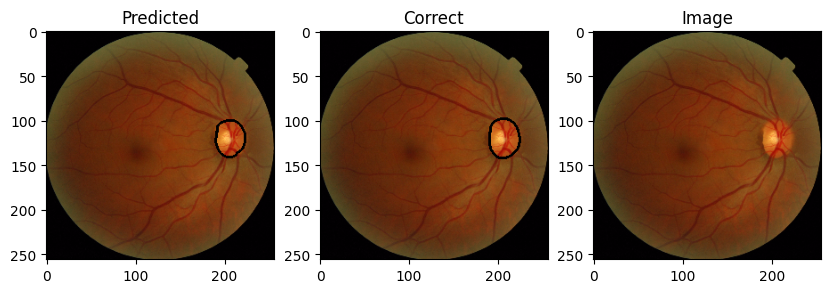

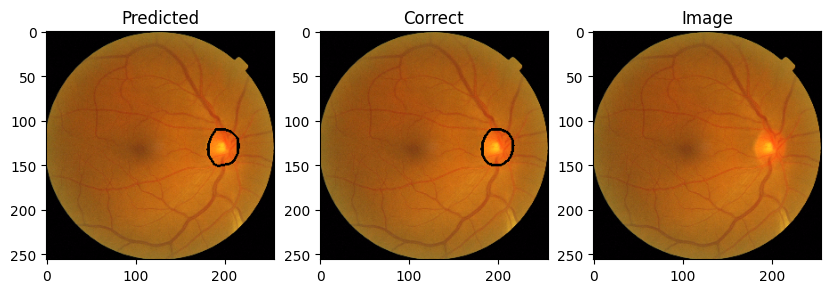

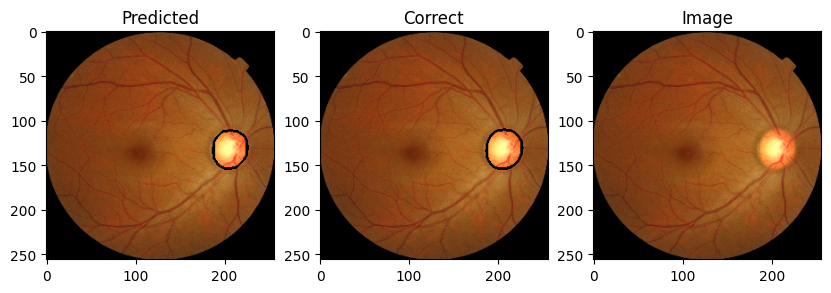

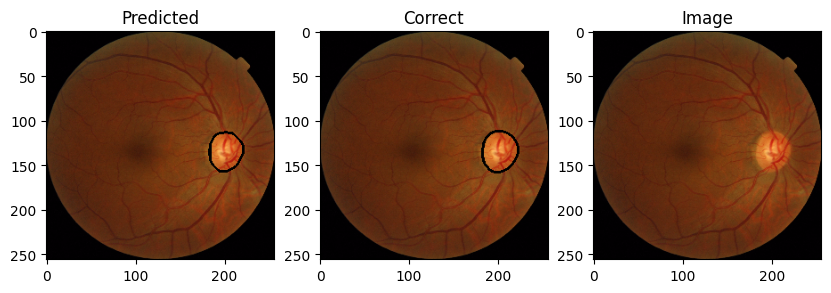

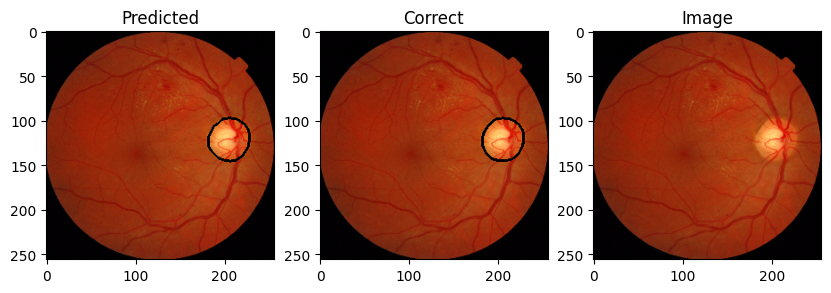

In [67]:
for image , mask, file_name in zip(sample_imgs, sample_masks, sample_fnames):

    temp = image.copy()
    temp = tf.image.resize(temp, (128, 128))/122.5 - 1.0

    mask = (mask[:, :, 0] > 100) + 0.0
    
    start_time = time.time()
    pred = (model.predict(tf.expand_dims(temp, axis=0), verbose=0)[0] > 0.5).astype(float)
    end_time = time.time()
    print(f"Time taken to predict: {end_time - start_time:.2f} seconds")
    pred = cv2.resize(pred, (256, 256))
    disc_pred.append(pred)

    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.set_title('Predicted')
    edgesp = canny(pred)
    edgesp = 1.0-dilation(edgesp)
    edgesp = color.gray2rgb(1.0*edgesp)
    ax.imshow((image*edgesp).astype(int)[:, :, ::-1])


    ax = fig.add_subplot(1, 3, 2)
    ax.set_title('Correct')
    edgesc = canny(mask)
    edgesc = 1.0-dilation(edgesc)
    edgesc = color.gray2rgb(1.0*edgesc)
    ax.imshow((image*edgesc).astype(int)[:, :, ::-1])

    ax = fig.add_subplot(1, 3, 3)
    ax.set_title('Image')
    ax.imshow(image[:, :, ::-1])

In [68]:
# Load the images and masks
MASK_DIR2 = "cup_masks"
images_arr2, masks_arr2, fnames2 = load_images(IMAGE_DIR, MASK_DIR2)
training_imgs2, training_masks2, training_fnames2, testing_imgs2, testing_masks2, testing_fnames2, train_indices2, test_indices2 = split_data(images_arr2, masks_arr2, fnames2, train_size=0.8, train_indices=train_indices, test_indices=test_indices, shuffle=False)

print(training_fnames2)
print(testing_fnames2)

['29.png', '90.png', '14.png', '15.png', '93.png', '32.png', '24.png', '97.png', '88.png', '52.png', '47.png', '40.png', '62.png', '92.png', '79.png', '23.png', '50.png', '57.png', '54.png', '31.png', '16.png', '77.png', '63.png', '51.png', '22.png', '94.png', '65.png', '86.png', '8.png', '17.png', '68.png', '75.png', '39.png', '78.png', '26.png', '25.png', '69.png', '38.png', '3.png', '27.png', '20.png', '70.png', '59.png', '67.png', '7.png', '99.png', '36.png', '44.png', '46.png', '5.png', '81.png', '61.png', '85.png', '11.png', '76.png', '48.png', '37.png', '84.png', '43.png', '6.png', '42.png', '41.png', '9.png', '12.png', '100.png', '64.png', '33.png', '71.png', '10.png', '96.png', '34.png', '74.png', '60.png', '55.png', '87.png', '19.png', '89.png', '35.png', '53.png', '58.png']
['73.png', '80.png', '66.png', '72.png', '91.png', '2.png', '4.png', '21.png', '18.png', '83.png', '28.png', '56.png', '98.png', '82.png', '95.png', '1.png', '45.png', '49.png', '13.png', '30.png']


In [16]:
# Build the model
cup_model = build_UNET()

# Display the model architecture
cup_model.summary()

# Compile the model
cup_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=get_log_dice_loss,
    metrics=[get_dice_coeff_metric, get_IoverU_metric]
)

Model: "Enhanced_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_19[0][0]']              
                                )                                                    

In [17]:
# Train the model
train_generator = dataYielder(training_imgs2, training_masks2, training=True)
validation_generator = dataYielder(testing_imgs2, testing_masks2, training=False)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
cup_model.fit(
    train_generator,
    steps_per_epoch=len(training_imgs2) // BATCH_SIZE,
    epochs=500,
    validation_data=validation_generator,
    validation_steps=len(testing_imgs2) // BATCH_SIZE,
    callbacks=[early_stopping]
)
# Save model named glaucoma_unet.h5
cup_model.save("glaucoma_unet_cup.h5")

Epoch 1/500
20/20 [==============================] - 3s 77ms/step - loss: 4.1185 - get_dice_coeff_metric: 0.0171 - get_IoverU_metric: 0.0143 - val_loss: 3.5387 - val_get_dice_coeff_metric: 0.0292 - val_get_IoverU_metric: 0.1211
Epoch 2/500
20/20 [==============================] - 1s 64ms/step - loss: 2.5435 - get_dice_coeff_metric: 0.1086 - get_IoverU_metric: 0.1386 - val_loss: 0.9638 - val_get_dice_coeff_metric: 0.4021 - val_get_IoverU_metric: 0.3159
Epoch 3/500
20/20 [==============================] - 1s 64ms/step - loss: 0.9194 - get_dice_coeff_metric: 0.4210 - get_IoverU_metric: 0.3090 - val_loss: 0.7165 - val_get_dice_coeff_metric: 0.4903 - val_get_IoverU_metric: 0.3405
Epoch 4/500
20/20 [==============================] - 1s 64ms/step - loss: 0.5936 - get_dice_coeff_metric: 0.5633 - get_IoverU_metric: 0.4150 - val_loss: 0.6825 - val_get_dice_coeff_metric: 0.5109 - val_get_IoverU_metric: 0.3579
Epoch 5/500
20/20 [==============================] - 1s 64ms/step - loss: 0.4839 - get_d

In [69]:
# take the same 5 random images from the testing set
sample_imgs2 = [testing_imgs2[i] for i in indices]
sample_masks2 = [testing_masks2[i] for i in indices]
sample_fnames2 = [testing_fnames2[i] for i in indices]
print(sample_fnames2)


['56.png', '73.png', '91.png', '1.png', '13.png']


Time taken to predict: 0.42 seconds
Time taken to predict: 0.08 seconds
Time taken to predict: 0.08 seconds
Time taken to predict: 0.07 seconds
Time taken to predict: 0.05 seconds


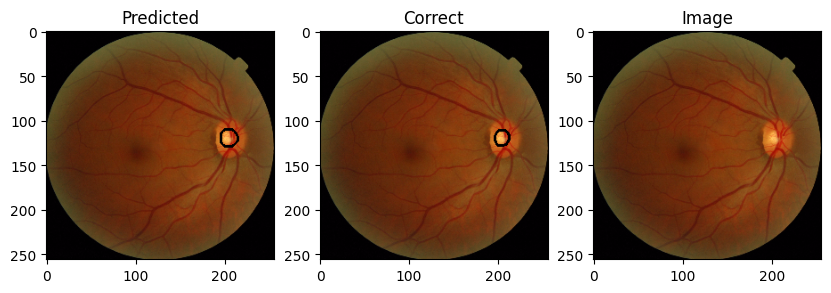

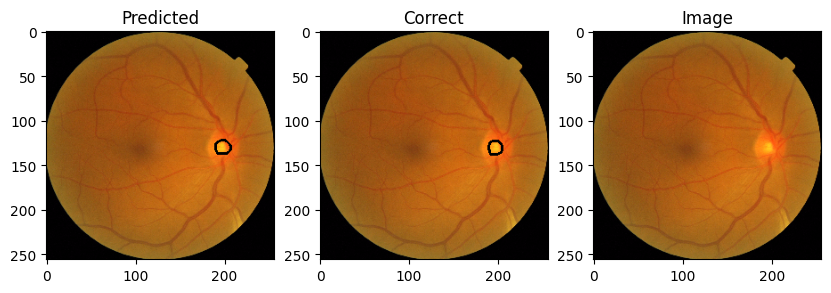

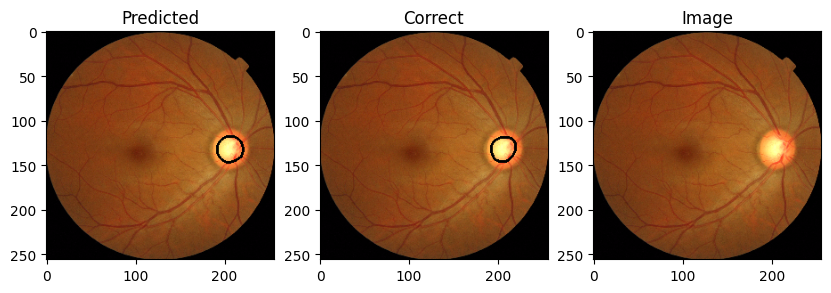

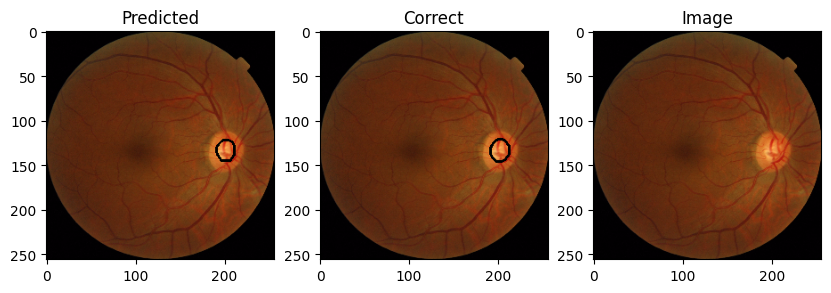

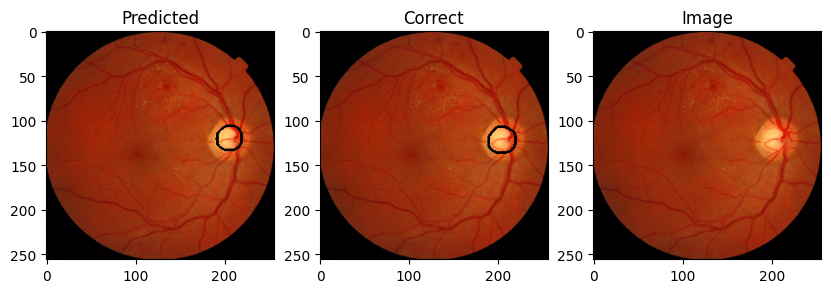

In [70]:
for image , mask, file_name in zip(sample_imgs2, sample_masks2, sample_fnames2):
    temp = image.copy()
    temp = tf.image.resize(temp, (128, 128))/122.5 - 1.0
    mask = (mask[:, :, 0] > 100) + 0.0
    
    start_time = time.time()
    pred = (cup_model.predict(tf.expand_dims(temp, axis=0), verbose=0)[0] > 0.5).astype(float)
    end_time = time.time()
    
    print(f"Time taken to predict: {end_time - start_time:.2f} seconds")
    pred = cv2.resize(pred, (256, 256))
    cup_pred.append(pred)

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 3, 1)
    ax.set_title('Predicted')
    edgesp = canny(pred)
    edgesp = 1.0-dilation(edgesp)
    edgesp = color.gray2rgb(1.0*edgesp)
    ax.imshow((image*edgesp).astype(int)[:, :, ::-1])


    ax = fig.add_subplot(1, 3, 2)
    ax.set_title('Correct')
    edgesc = canny(mask)
    edgesc = 1.0-dilation(edgesc)
    edgesc = color.gray2rgb(1.0*edgesc)
    ax.imshow((image*edgesc).astype(int)[:, :, ::-1])

    ax = fig.add_subplot(1, 3, 3)
    ax.set_title('Image')
    ax.imshow(image[:, :, ::-1])

[0.29454545454545455, 0.20141342756183744, 0.5089285714285714, 0.303951367781155, 0.37155963302752293]
5
5
5


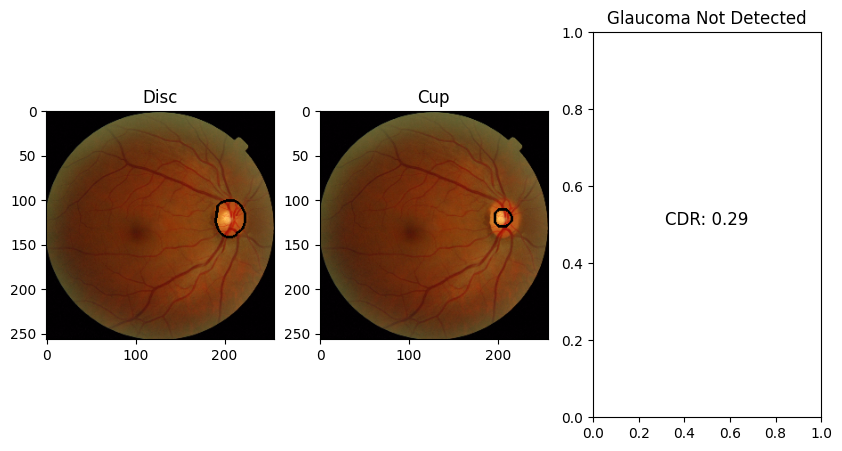

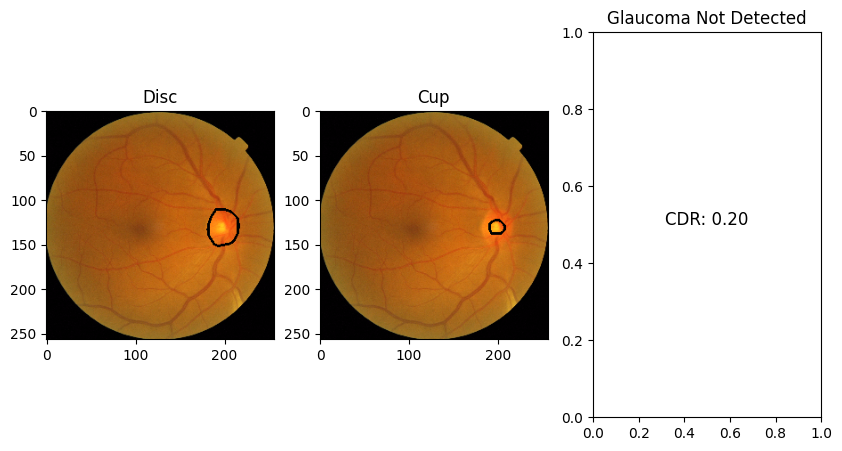

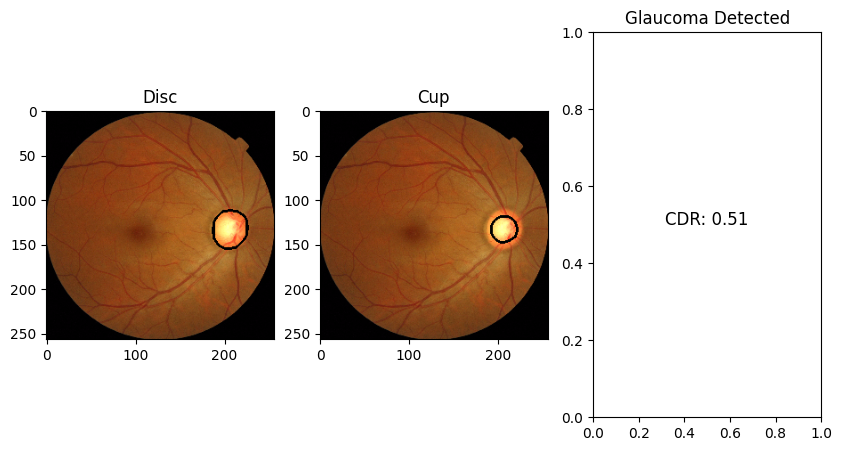

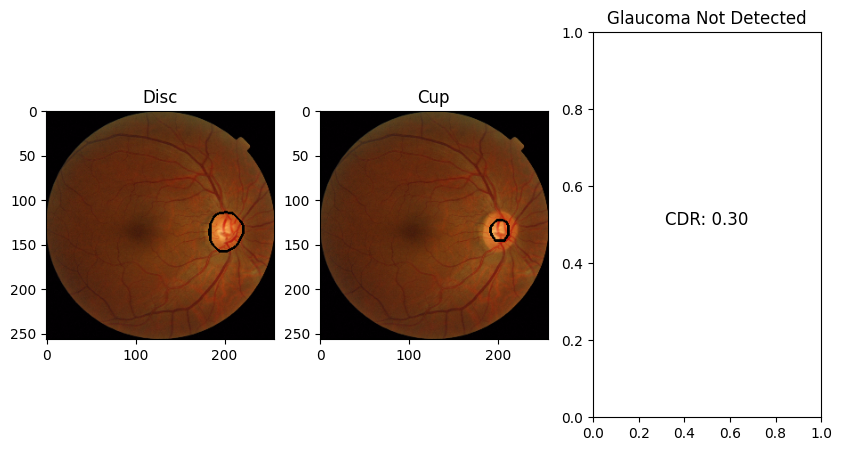

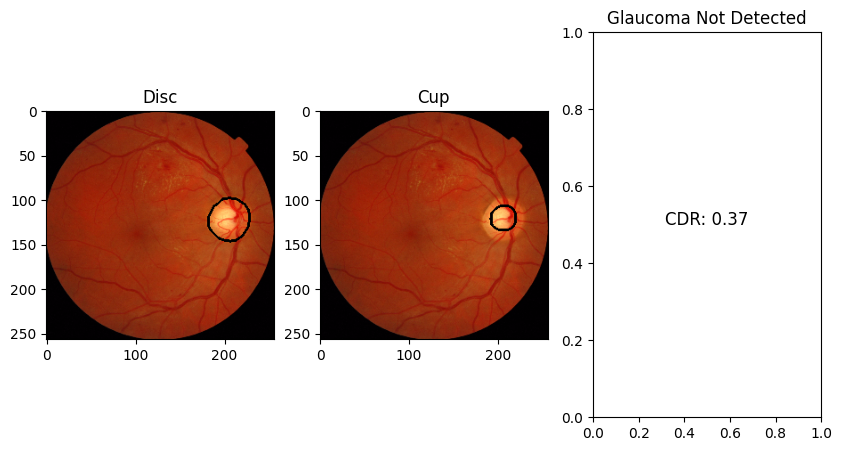

In [72]:
def compute_cdr(disc_mask, cup_mask):
    disc_area = np.sum(disc_mask)
    cup_area = np.sum(cup_mask)
    cdr = cup_area / disc_area
    return cdr

cdr_values = []
for disc, cup in zip(disc_pred, cup_pred):
    cdr = compute_cdr(disc, cup)
    cdr_values.append(cdr)

print(cdr_values)
print(len(cdr_values))
print(len(disc_pred))
print(len(cup_pred))

for i, (disc, cup, cdr) in enumerate(zip(disc_pred, cup_pred, cdr_values)):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 3, 1)
    ax.set_title('Disc')
    edgesp = canny(disc)
    edgesp = 1.0-dilation(edgesp)
    edgesp = color.gray2rgb(1.0*edgesp)
    ax.imshow((sample_imgs[i]*edgesp).astype(int)[:, :, ::-1])

    ax = fig.add_subplot(1, 3, 2)
    ax.set_title('Cup')
    edgesc = canny(cup)
    edgesc = 1.0-dilation(edgesc)
    edgesc = color.gray2rgb(1.0*edgesc)
    ax.imshow((sample_imgs[i]*edgesc).astype(int)[:, :, ::-1])

    if cdr > 0.5:
        # Glaucoma detected
        ax = fig.add_subplot(1, 3, 3)
        ax.set_title('Glaucoma Detected')
        ax.text(0.5, 0.5, f"CDR: {cdr:.2f}", fontsize=12, ha='center')
    else:
        ax = fig.add_subplot(1, 3, 3)
        ax.set_title('Glaucoma Not Detected')
        ax.text(0.5, 0.5, f"CDR: {cdr:.2f}", fontsize=12, ha='center')

        